In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots 
plt.style.use(['science','no-latex'])

import os
notebook_abs_path = os.path.abspath(os.getcwd())
REPO_ROOT = os.path.join(notebook_abs_path, os.pardir, os.pardir)

import sys
sys.path.append(REPO_ROOT)

from nebula.misc.plots import set_size

def read_metrics_file(metrics_file_fullpath):
    metrics = pd.read_csv(metrics_file_fullpath)
    return metrics

def walk_training_folder(training_folder, metric, skip=[]):
    output_df = pd.DataFrame() # should have structure: index => steps; columns => number of families; values => metric
    for root, subdirs, files in os.walk(training_folder):
        for subdir in subdirs:
            if 'nr_families' in subdir and subdir.endswith('csv'):
                nr_of_families = int(subdir.split('nr_families_')[1].split('_')[0])
                if "dropout" in training_folder:
                    model = subdir.split('_')[0] + "_dropout0.5" if "0.5" in training_folder else subdir.split('_')[0] + "_dropout0.3"
                elif "adam" in training_folder:
                    model = subdir.split('_')[0] + "_adam"
                else:
                    model = subdir.split('_')[0]
                if model in skip:
                    continue
                metrics_file_fullpath = os.path.join(training_folder, subdir, "version_0", "metrics.csv")
                if os.path.exists(metrics_file_fullpath):
                    metrics = read_metrics_file(metrics_file_fullpath)
                else:
                    metrics = pd.DataFrame()
                output_df[nr_of_families] = metrics[metric]
    # order columns by number of families
    output_df = output_df.reindex(sorted(output_df.columns), axis=1)
    return model, output_df
                
def read_stats(outfolder, metric, skip=[], training_prefix="training"):
    # metrics val_loss,val_f1,val_tpr,val_acc,val_auc,val_recall,val_precision,train_f1,train_tpr,train_acc,train_auc,train_recall,train_precision
    results = {}
    # results will have structure: index => nr of families; columns => model type; values => metric
    for root, dirs, files in os.walk(outfolder):
        for d in dirs:
            if not d.startswith(training_prefix):
                continue
            training_folder = os.path.join(outfolder, d)
            model, model_metric_df = walk_training_folder(training_folder, metric, skip)
            results[model] = model_metric_df
    return results

def carve_out_stat(results, how='last'):
    assert how in ['last', 'best']
    output = pd.DataFrame()

    for model in results.keys():
        for col in results[model].columns:
            # print(col, results['nebulabpe'][col].dropna().shape)
            try:
                if how == 'best':
                    last_val = results[model][col].dropna().values.max()
                elif how == 'last':
                    last_val = results[model][col].dropna().values[-1]
                output.at[model, col] = last_val
            except:
                pass
                
    return output

def line_scatter_plot_stat(stat_df, skip=[], ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    
    for model in stat_df.T.columns:
        if model in skip:
            continue
        ax.plot(stat_df.T.index, stat_df.T[model], linestyle='--', marker='o', label=model)

    ax.legend()
    return ax

# Speakeasy Run

In [131]:
outfolder = 'out_family_downscale_speakeasy_PROD'

,3,4,5,6,7,8
nebulabpe,0.827521,0.447370,0.241869,0.110623,0.093839,0.078745
nebulawht,0.772349,0.310831,0.140072,0.110636,0.093850,0.078754
neurlux,0.265644,0.188988,0.140052,0.110623,0.093839,0.078745


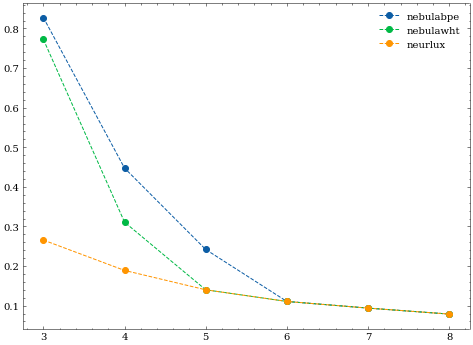

In [76]:
results = read_stats(outfolder, 'val_f1', skip=['dmds'], training_prefix="ordered")
stat_df = carve_out_stat(results, how='best')
line_scatter_plot_stat(stat_df)
stat_df

,3,4,5,6,7,8
nebulabpe,0.873376,0.721075,0.575458,0.496711,0.489063,0.459815
nebulawht,0.846631,0.623680,0.538886,0.496803,0.489151,0.459890
neurlux,0.662418,0.607653,0.538772,0.496711,0.489063,0.459815


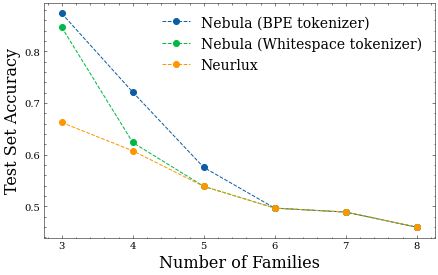

In [132]:
fig, ax = plt.subplots(figsize=set_size())

# results = read_stats(outfolder, 'val_acc', skip=['nebulabpe_dropout0.5', 'nebulawht_dropout0.5'])
# stat_df = carve_out_stat(results, how='best')
# ax = line_scatter_plot_stat(stat_df, ax=ax)
results = read_stats(outfolder, 'val_acc', skip=['dmds'], training_prefix="ordered")
stat_df = carve_out_stat(results, how='best')
ax = line_scatter_plot_stat(stat_df, ax=ax)

# ax.set_ylim(0.85, 1.01)
handles, labels = ax.get_legend_handles_labels()
labels_new = [
    'Nebula (BPE tokenizer)',
    'Nebula (Whitespace tokenizer)',
    'Neurlux'
]
ax.legend(
    loc='upper right',
    fontsize=14,
    labels=labels_new,#[::-1],
    handles=handles,#[::-1]
)

ax.set_xlabel('Number of Families', fontsize=16)
ax.set_ylabel('Test Set Accuracy', fontsize=16)
stat_df

# fig = ax.get_figure()
fig.savefig(os.path.join('img', 'family_downscale_speakeasy.pdf'), dpi=300, bbox_inches='tight')

stat_df

,3,4,5,6,7,8
nebulabpe,0.960276,0.900133,0.759407,0.673682,0.687519,0.597912
nebulawht,0.854519,0.778755,0.679984,0.720676,0.678781,0.575799
neurlux,0.567444,0.686608,0.588897,0.631440,0.594917,0.639232


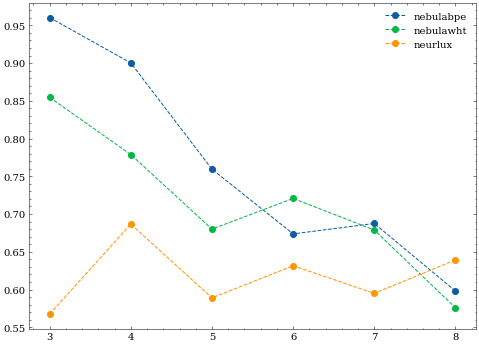

In [80]:
results = read_stats(outfolder, 'val_auc', skip=['dmds'], training_prefix="ordered")
stat_df = carve_out_stat(results, how='best')
line_scatter_plot_stat(stat_df)
stat_df

,3,4,5,6,7,8
nebulabpe,0.485001,0.231672,0.089069,0.062869,0.043397,0.078745
nebulawht,0.492964,0.187657,0.097116,0.058327,0.080150,0.078754
neurlux,0.207698,0.133462,0.108826,0.058306,0.052959,0.078745
quovadis,0.284996,0.208631,0.145288,0.198303,0.061047,0.084761


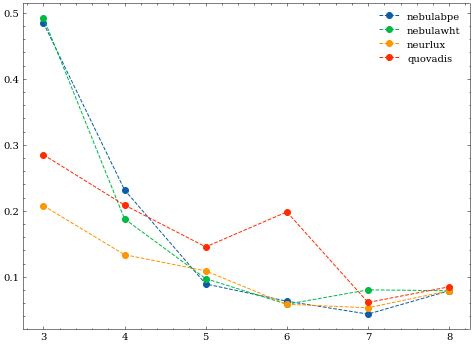

In [49]:
results = read_stats(outfolder, 'val_f1', skip=['dmds'])
stat_df = carve_out_stat(results, how='best')
line_scatter_plot_stat(stat_df)
stat_df

,3,4,5,6,7,8
nebulabpe,0.882113,0.629999,0.577429,0.525133,0.526552,0.542905
nebulawht,0.944619,0.716362,0.538673,0.557146,0.532409,0.575506
neurlux,0.707048,0.671441,0.629171,0.500526,0.530466,0.590805


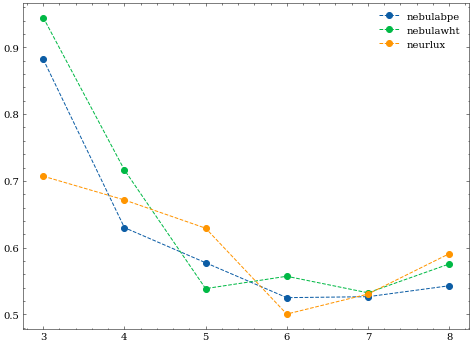

In [43]:
results = read_stats(outfolder, 'val_auc', skip=['dmds', 'quovadis'])
stat_df = carve_out_stat(results, how='best')
line_scatter_plot_stat(stat_df)
stat_df

,3,4,5,6,7,8
nebulabpe,0.619314,0.364114,0.286460,0.211671,0.179092,0.459815
nebulawht,0.633201,0.386739,0.286614,0.212091,0.194382,0.459890
neurlux,0.452531,0.364114,0.286594,0.211999,0.227481,0.459815


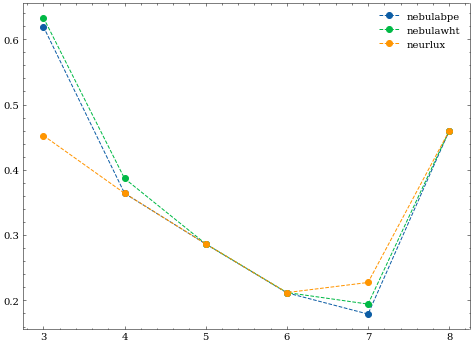

In [52]:
results = read_stats(outfolder, 'val_acc', skip=['dmds', 'quovadis'])
stat_df = carve_out_stat(results, how='best')
line_scatter_plot_stat(stat_df)
stat_df

,3,4,5,6,7,8
nebulabpe,0.544921,0.462145,0.622424,0.707936,0.758323,0.738046
nebulawht,0.556005,0.481645,0.626524,0.760735,0.758242,0.771594
neurlux,0.199814,0.408321,0.495518,0.063491,0.086112,0.577308
quovadis,0.611439,0.431176,0.467509,0.319761,0.179429,0.265562


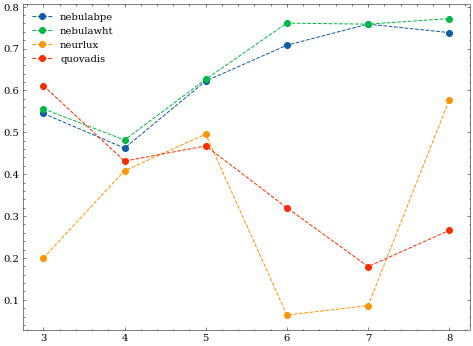

In [5]:
results = read_stats(outfolder, 'train_f1', skip=['dmds'])
stat_df = carve_out_stat(results, how='last')
line_scatter_plot_stat(stat_df)
stat_df

,3,4,5,6,7,8
nebulabpe,0.793080,0.607808,0.779613,0.827860,0.831804,0.846229
nebulawht,0.809548,0.656848,0.765776,0.843395,0.836145,0.843953
neurlux,0.428002,0.551160,0.614681,0.177694,0.134242,0.740851
quovadis,0.883476,0.753138,0.703563,0.497744,0.247609,0.429170


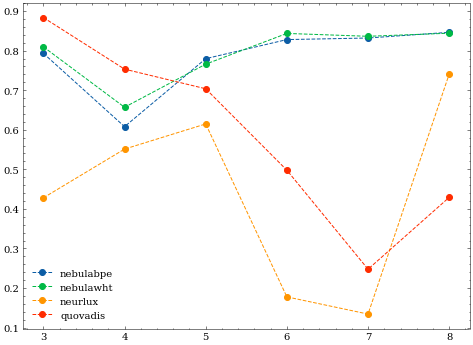

In [6]:
results = read_stats(outfolder, 'train_acc', skip=['dmds'])
stat_df = carve_out_stat(results, how='last')
line_scatter_plot_stat(stat_df)
stat_df

,3,4,5,6,7,8
nebulabpe,0.619314,0.364114,0.286460,0.211671,0.179092,0.459815
nebulawht,0.633201,0.386739,0.286614,0.212091,0.194382,0.459890
neurlux,0.452531,0.364114,0.286594,0.211999,0.227481,0.459815
quovadis,0.455330,0.387387,0.321816,0.275161,0.115814,0.459815


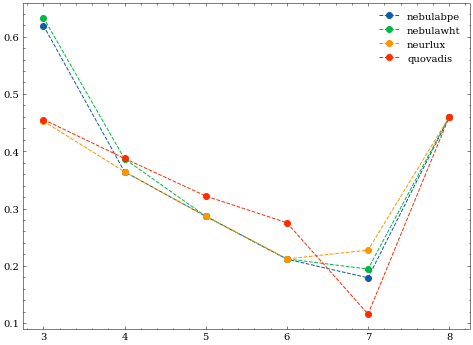

In [7]:
results = read_stats(outfolder, 'val_acc', skip=['dmds'])
stat_df = carve_out_stat(results, how='best')
line_scatter_plot_stat(stat_df)
stat_df

,3,4,5,6,7,8
nebulabpe,0.485001,0.231672,0.089069,0.062869,0.043397,0.078745
nebulawht,0.492964,0.187657,0.097116,0.058327,0.080150,0.078754
neurlux,0.207698,0.133462,0.108826,0.058306,0.052959,0.078745
quovadis,0.284996,0.208631,0.145288,0.198303,0.061047,0.084761


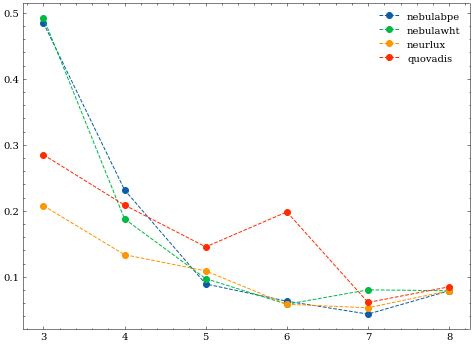

In [8]:
results = read_stats(outfolder, 'val_f1', skip=['dmds'])
stat_df = carve_out_stat(results, how='best')
line_scatter_plot_stat(stat_df)
stat_df

# Avast-CTU Data Run

In [126]:
outfolder = 'out_family_downscale_avast_PROD'

,3,4,5,6,7,8,9,10
nebulabpe_dropout0.3,0.983935,0.915005,0.869173,0.900600,0.869274,0.903089,0.902086,0.813340
nebulawht_dropout0.3,0.990936,0.931657,0.871326,0.885501,0.882261,0.881100,0.901162,0.812482
neurlux,0.993344,0.945289,0.926266,0.930289,0.914178,0.927145,0.907507,0.892857


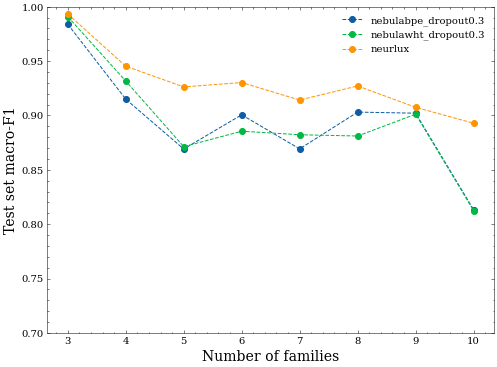

In [127]:
results = read_stats(outfolder, 'val_f1', skip=['nebulabpe_dropout0.5', 'nebulawht_dropout0.5'])
stat_df = carve_out_stat(results, how='best')
ax = line_scatter_plot_stat(stat_df)
ax.set_ylim(0.7, 1)
ax.set_xlabel('Number of families', fontsize=14)
ax.set_ylabel('Test set macro-F1', fontsize=14)
stat_df

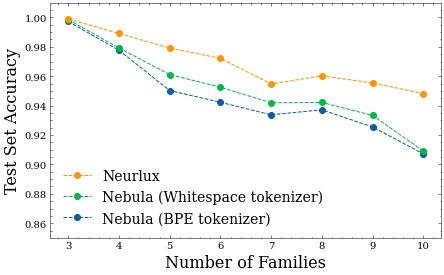

In [130]:
fig,ax = plt.subplots(figsize=set_size())

results = read_stats(outfolder, 'val_acc', skip=['nebulabpe_dropout0.5', 'nebulawht_dropout0.5'])
stat_df = carve_out_stat(results, how='best')
ax = line_scatter_plot_stat(stat_df, ax=ax)
ax.set_ylim(0.85, 1.01)
handles, labels = ax.get_legend_handles_labels()
labels_new = [
    'Nebula (BPE tokenizer)',
    'Nebula (Whitespace tokenizer)',
    'Neurlux'
]
ax.legend(
    loc='lower left',
    fontsize=14,
    labels=labels_new[::-1],
    handles=handles[::-1]
)
ax.set_xlabel('Number of Families', fontsize=16)
ax.set_ylabel('Test Set Accuracy', fontsize=16)
stat_df

# fig = ax.get_figure()
fig.savefig(os.path.join('img', 'family_downscale_avast.pdf'), dpi=300, bbox_inches='tight')

,3,4,5,6,7,8,9,10
neurlux_adam,0.999922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nebulabpe_dropout0.3,0.999789,0.996311,0.997697,0.993361,0.993016,0.993136,0.995523,0.992173
nebulawht_dropout0.3,0.999803,0.998721,0.995848,0.994961,0.993973,0.995502,0.994800,0.990650
neurlux,0.999934,0.999072,0.999215,0.998850,0.998603,0.998407,0.997380,0.996724


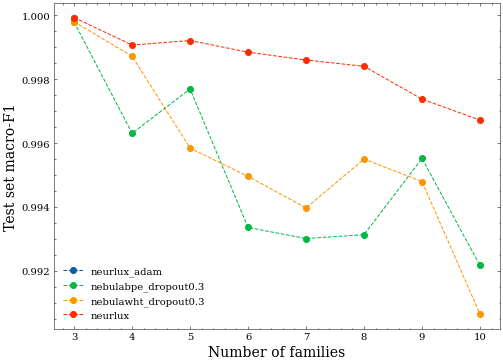

In [65]:
results = read_stats(outfolder, 'val_auc', skip=['nebulabpe_dropout0.5', 'nebulawht_dropout0.5'])
stat_df = carve_out_stat(results, how='best')
ax = line_scatter_plot_stat(stat_df)
ax.set_xlabel('Number of families', fontsize=14)
ax.set_ylabel('Test set macro-F1', fontsize=14)
stat_df

,3,4,5,6,7,8,9,10
nebulabpe_dropout0.3,0.996072,0.993918,0.992986,0.988706,0.978661,0.978523,0.978968,0.967651
nebulawht_dropout0.3,0.995847,0.994060,0.992209,0.989617,0.983146,0.987023,0.973892,0.960554
neurlux,0.981391,0.985383,0.979698,0.964498,0.943193,0.941752,0.917699,0.885254


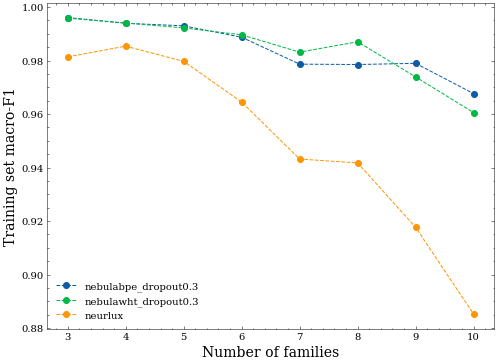

In [19]:
results = read_stats(outfolder, 'train_f1', skip=['nebulabpe_dropout0.5', 'nebulawht_dropout0.5'])
stat_df = carve_out_stat(results, how='best')
ax = line_scatter_plot_stat(stat_df)
ax.set_xlabel('Number of families', fontsize=14)
ax.set_ylabel('Training set macro-F1', fontsize=14)
stat_df